# 06. Gene Regulatory Network Inference

This notebook will introduce the usage of gene regulatory network inference after fitting velocity model

In [1]:
import pygot
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
plt.rc('axes.spines', top=False, right=False)
%matplotlib inline

## loading simulation data and preprocess

In [2]:
adata = pygot.datasets.synthetic()
time_key = 'Day'

This data is generated from a gene regulatory network of 18 genes, which drives cells differentiate
into three different cell type. The groundtruth stored in adata.uns['ref_network'] and the groundtruth
velocity store in adata.layers['velocity_groundtruth'] The underlying GRN is

![GRN](https://raw.githubusercontent.com/Witiy/WitiyImage/img/img/20240904105501.png)  

and show in the dataframe format


In [3]:
ref_network = adata.uns['ref_network']
ref_network.head()

,Gene2,Gene1,Type
0,g3,g2,+
1,g5,g4,+
2,g18,g17,+
3,g18,g18,+
4,g1,g18,-


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


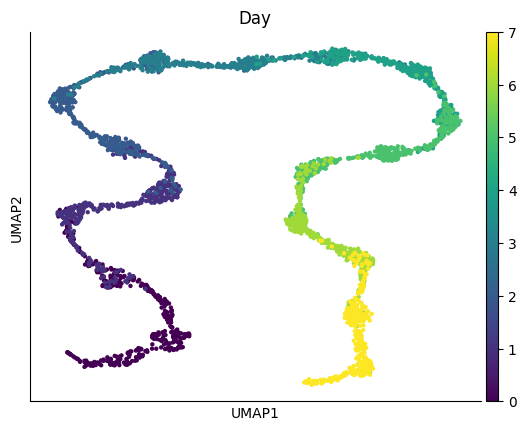

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=time_key)

### Using VAE to perform non-linear dimension reduction

we use VAE from `pygot.pp.GS_VAE` to train the VAE model. The inverse_transform function is already defined as `vae.inverse_transform` 

In [5]:
vae = pygot.preprocessing.GS_VAE()
vae.register_model(adata, latent_dim=2)
adata.obsm['X_latent'] = vae.fit_transform(adata, n_epoch=100)

To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :68.2939: 100%|██████████| 100/100 [00:02<00:00, 33.52it/s]


In here, we train the velocity model in both orginal and vae space to infer the gene velocity. For vae model, we use the decoder of VAE and chain rule to obtain gene velocity via latent velocity.

In [6]:
embedding_key = 'X_origin'
model_origin, history = pygot.tl.traj.fit_velocity_model(
            adata, time_key, embedding_key, v_centric_iter_n=500, x_centric_iter_n=1000)

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0.0to1.0.pkl'
Error in loading shortest path file
calcu shortest path between 0.0 to 1.0


100%|██████████| 375/375 [00:00<00:00, 2142.55it/s]


calcu shortest path between 1.0 to 2.0


100%|██████████| 375/375 [00:00<00:00, 4310.63it/s]


calcu shortest path between 2.0 to 3.0


100%|██████████| 375/375 [00:00<00:00, 4260.35it/s]


calcu shortest path between 3.0 to 4.0


100%|██████████| 375/375 [00:00<00:00, 4096.47it/s]


calcu shortest path between 4.0 to 5.0


100%|██████████| 375/375 [00:00<00:00, 4222.01it/s]


calcu shortest path between 5.0 to 6.0


100%|██████████| 375/375 [00:00<00:00, 4256.19it/s]


calcu shortest path between 6.0 to 7.0


loss :9.0808  best :9.0808: 100%|██████████| 1000/1000 [00:20<00:00, 47.96it/s] 


In [7]:
embedding_key = 'X_latent'
model_latent, history = pygot.tl.traj.fit_velocity_model(
            adata, time_key, embedding_key, v_centric_iter_n=500, x_centric_iter_n=1000)

loading saved shortest path profile
[Errno 2] No such file or directory: '/_0.0to1.0.pkl'
Error in loading shortest path file
calcu shortest path between 0.0 to 1.0


100%|██████████| 375/375 [00:00<00:00, 3645.69it/s]


calcu shortest path between 1.0 to 2.0


100%|██████████| 375/375 [00:00<00:00, 3592.54it/s]


calcu shortest path between 2.0 to 3.0


100%|██████████| 375/375 [00:00<00:00, 4230.13it/s]


calcu shortest path between 3.0 to 4.0


100%|██████████| 375/375 [00:00<00:00, 4304.70it/s]


calcu shortest path between 4.0 to 5.0


100%|██████████| 375/375 [00:00<00:00, 4148.00it/s]


calcu shortest path between 5.0 to 6.0


100%|██████████| 375/375 [00:00<00:00, 4152.23it/s]


calcu shortest path between 6.0 to 7.0


loss :0.7151  best :0.7082: 100%|██████████| 1000/1000 [00:21<00:00, 46.66it/s]


## Comparsion velocity accuracy between origin and VAE space

After training, we can transform the latent velocity into 2-d umap velocity to velocity. Both the umap velocity obtained from origin and vae are very close to groundtruth velocity.

computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
Use adata.obsp['connectivities'] as neighbors, please confirm it is computed in embedding space
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Axes: title={'center': 'Predicition (VAE)'}>

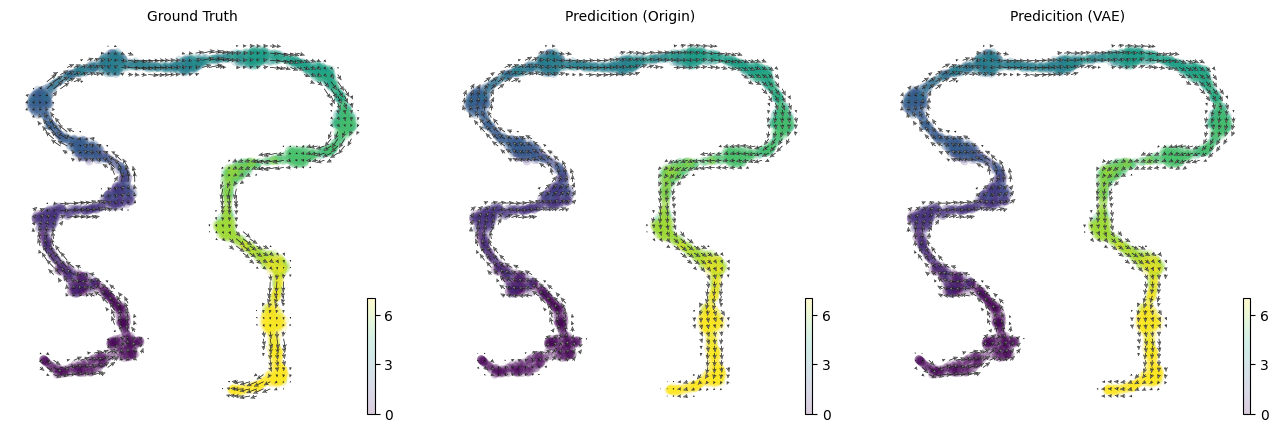

In [8]:

import scvelo as scv
fig, axs = plt.subplots(1,3, figsize=(16, 5))
adata.layers['velocity'] = adata.layers['velocity_groundtruth']

adata.layers['Ms'] = adata.X
scv.tl.velocity_graph(adata)
true_latent_v = adata.layers['velocity'] @ adata.varm['PCs']
scv.pl.velocity_embedding_grid(adata, basis='umap', 
                                        ax=axs[0], arrow_size=2, arrow_length=2, color=time_key, show=False, title='Ground Truth')

#origin
embedding_key = 'X_origin'
origin2gene_velocity = pygot.tl.traj.velocity(adata, model_origin.func, time_key=time_key, embedding_key=embedding_key, A=np.eye(adata.shape[1]))
adata.layers['velocity'] = origin2gene_velocity
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key='velocity_origin')
del adata.obsm['velocity_umap']
scv.pl.velocity_embedding_grid(adata, basis='umap', ax=axs[1], arrow_size=2, arrow_length=2,color=time_key, show=False, title='Predicition (Origin)')


#vae
embedding_key = 'X_latent'
vae2gene_velocity = pygot.tl.traj.velocity(adata, model_latent.func, embedding_key=embedding_key, time_key=time_key, dr_mode='nonlinear', inverse_transform=vae.inverse_transform)
adata.layers['velocity'] = vae2gene_velocity
pygot.tl.traj.velocity_graph(adata, embedding_key=embedding_key, velocity_key='velocity_latent')
del adata.obsm['velocity_umap']
scv.pl.velocity_embedding_grid(adata, basis='umap', ax=axs[2], arrow_size=2, arrow_length=2, color=time_key, show=False, title='Predicition (VAE)')




Next, we compare the gene velocity directly infered from original space / the recovered gene velocity from vae space with groundtruth gene velocity

In [9]:
true_velo = adata.layers['velocity_groundtruth']

Significantly, they have comparable accuracy

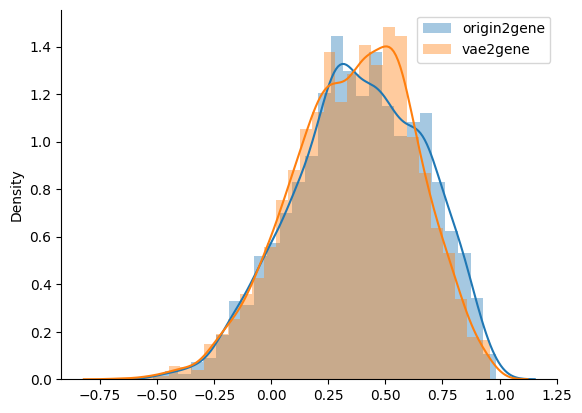

In [10]:
cos_similarity_with_pca = np.sum(origin2gene_velocity * true_velo, axis=1) / (np.linalg.norm(origin2gene_velocity, axis=1)*np.linalg.norm(true_velo, axis=1))
cos_similarity_with_vae = np.sum(vae2gene_velocity * true_velo, axis=1) / (np.linalg.norm(vae2gene_velocity, axis=1)*np.linalg.norm(true_velo, axis=1))
sns.distplot(cos_similarity_with_pca, label='origin2gene')
sns.distplot(cos_similarity_with_vae, label='vae2gene')
plt.legend()

## Gene regulatory network inference

Finally, we can use the gene velocity to construct a regression model to infer the gene regulatory network (GRN), and evalute the performance by compute area under curve of precision and recall (AUCPR) value between groundtruth GRN and infered GRN.

In [11]:
grn = pygot.tl.analysis.GRN()
adata.layers['velocity'] = pygot.tl.traj.latent_velocity(adata, model_origin.func, embedding_key='X_origin', time_key=time_key)
grn_data_origin = grn.fit(adata, TF_constrain=False, non_negative=False)
print('PR:', pygot.evalute.compute_pr(adata.uns['ref_network'], grn_data_origin.ranked_edges))

TF number: 18, Index(['g1', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18',
       'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9'],
      dtype='object')
scale velocity with factor : 3.0845143883801915
l1_penalty: 0.005 min_beta: 1.0


Epoch [6943/10000], Train Loss: 2.6323, Val Loss: 1.3067:  69%|██████▉   | 6943/10000 [00:08<00:03, 801.70it/s]


Early stopping at epoch 6944. Best validation loss: 1.30654
PR: 0.934571702244116


In [12]:
grn = pygot.tl.analysis.GRN()
adata.layers['velocity'] = vae2gene_velocity
grn_data_latent = grn.fit(adata, TF_constrain=False, non_negative=False)
print('PR:', pygot.evalute.compute_pr(adata.uns['ref_network'], grn_data_latent.ranked_edges))

TF number: 18, Index(['g1', 'g10', 'g11', 'g12', 'g13', 'g14', 'g15', 'g16', 'g17', 'g18',
       'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9'],
      dtype='object')
scale velocity with factor : 3.1818997927513477
l1_penalty: 0.005 min_beta: 1.0


Epoch [6424/10000], Train Loss: 2.0883, Val Loss: 1.0623:  64%|██████▍   | 6424/10000 [00:08<00:04, 772.85it/s]


Early stopping at epoch 6425. Best validation loss: 1.06216
PR: 0.9223086330116774


The infered GRNs are accurate and with high and close AUCPR value

In [13]:
ref_matrix = np.zeros(shape=(len(adata.var), len(adata.var)))
ref_matrix[adata.var.loc[adata.uns['ref_network'].loc[adata.uns['ref_network']['Type'] == '+'].Gene2.tolist()]['idx'].tolist(), 
           adata.var.loc[adata.uns['ref_network'].loc[adata.uns['ref_network']['Type'] == '+'].Gene1.tolist()]['idx'].tolist()] = 1

ref_matrix[adata.var.loc[adata.uns['ref_network'].loc[adata.uns['ref_network']['Type'] == '-'].Gene2.tolist()]['idx'].tolist(), 
           adata.var.loc[adata.uns['ref_network'].loc[adata.uns['ref_network']['Type'] == '-'].Gene1.tolist()]['idx'].tolist()] = -1

Visualization of GRN

Text(0.5, 1.0, 'GRN (latent)')

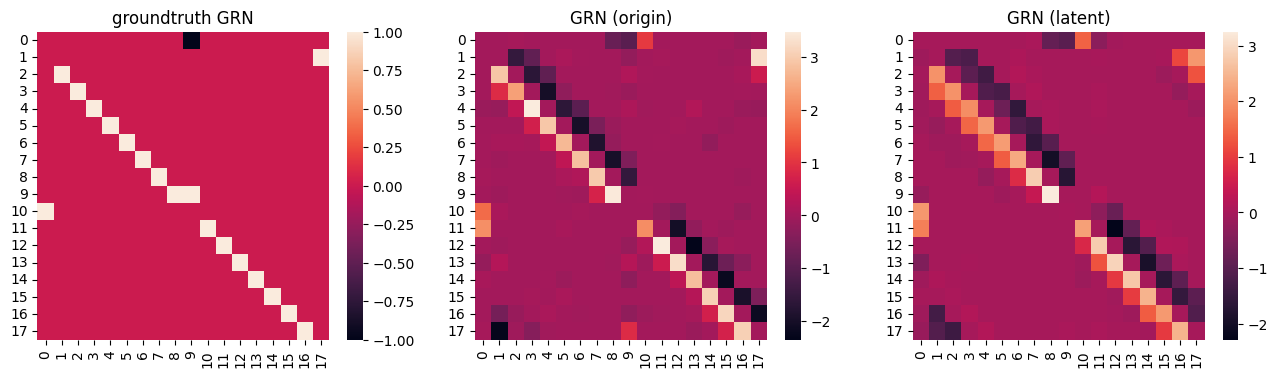

In [14]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.heatmap(ref_matrix, ax=axes[0])
axes[0].set_title('groundtruth GRN')
sns.heatmap(grn_data_origin.G, ax=axes[1])
axes[1].set_title('GRN (origin)')
sns.heatmap(grn_data_latent.G, ax=axes[2])
axes[2].set_title('GRN (latent)')